# Customer Churn Analysis

This notebook is using customer churn data from Kaggle (https://www.kaggle.com/sandipdatta/customer-churn-analysis) and has been adopted from the notebook available on Kaggle developed by SanD.

The notebook will go through the following steps:
    1. Import Dataset
    2. Analyze the Data
    3. Prepare the data model building
    4. Split data in test and train data
    5. Train model using various machine learning algorithms for binary classification
    6. Evaluate the models
    7. Select the model best fit for the given data set
    8. Save and deploy model to Watson Machine Learning

In [2]:
from sklearn import model_selection
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

In [3]:
%matplotlib inline 

from IPython.display import Image
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import seaborn as sns
import json

## Dataset

The original dataset can be downloaded from https://www.kaggle.com/becksddf/churn-in-telecoms-dataset/data. Then upload it to IBM Watson Studio and insert the code to read the data using "insert to code > Insert panndas DataFrame".

In [5]:
# @hidden_cell
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_931d06c29a624816bb257512bafae77d = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='KZoBr2MTLsSd0GYgLw9A17-hwnfmTdSNpH51EX06ntuE',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_931d06c29a624816bb257512bafae77d.get_object(Bucket='luxuryvehiclechurn-donotdelete-pr-ki69si3rt8w7oy',Key='sample_vehicle_customer_churn_dataframe.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()
# make sure you assign the dataframe to the variable "df"
df = df_data_1
print (df.shape)

(39, 9)


Examine the first 5 lines of the input

In [6]:
df.head()

,Unnamed: 0,State,Income,age,gender,personality,occupation,car hobby,churn
0,0,CA,"$400,000.00",33,male,disagreeable,attorney,yes,True
1,1,FL,"$150,000.00",62,female,disagreeable,retired,no,True
2,2,TX,"$80,000.00",44,male,agreeable,plumber,no,False
3,3,NY,"$115,000.00",38,male,disagreeable,banker,no,False
4,4,NV,"$165,000.00",52,male,agreeable,businessman,yes,True


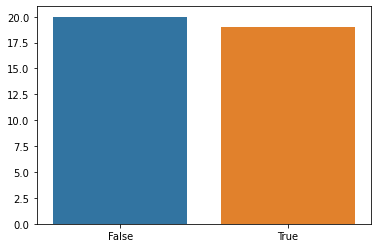

In [7]:
y = df["churn"].value_counts()
sns.barplot(y.index, y.values)

In [8]:
y_True = df["churn"][df["churn"] == True]
print ("Churn Percentage = "+str( (y_True.shape[0] / df["churn"].shape[0]) * 100 ))

Churn Percentage = 48.717948717948715


## Descriptive Analysis of the Data

In [9]:
  df.describe()

,Unnamed: 0,age
count,39.000000,39.000000
mean,19.000000,40.641026
std,11.401754,12.564543
min,0.000000,18.000000
25%,9.500000,32.500000
50%,19.000000,39.000000
75%,28.500000,45.000000
max,38.000000,70.000000


### Churn by State 

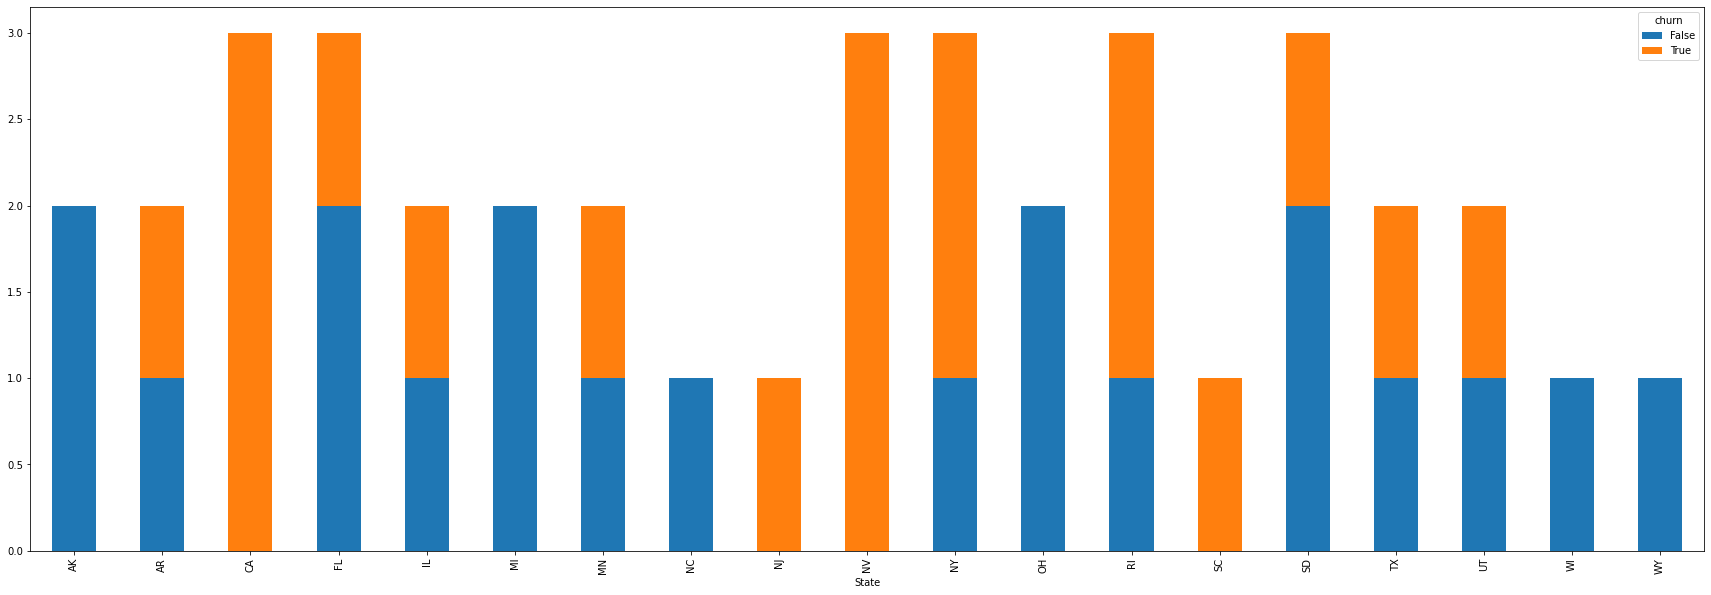

In [11]:
df.groupby(["State", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10)) 

### Churn by Income

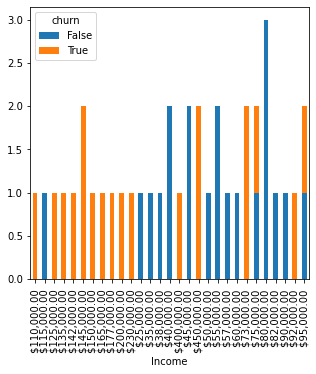

In [13]:
df.groupby(["Income", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

###  Churn by customers with occupation 

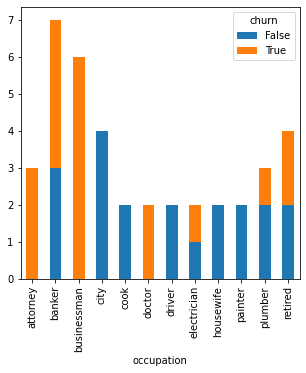

In [14]:
df.groupby(["occupation", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

### Churn By Customers with car hobby

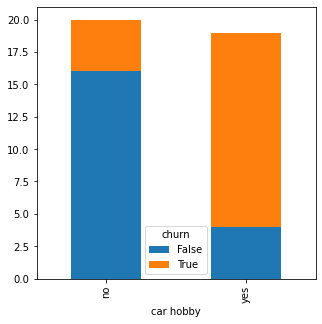

In [15]:
df.groupby(["car hobby", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

## Data Preparation

The following preprocessing steps need to be done:
1. Turn categorical variables into discrete numerical variables
2. Create response vector
3. Drop superflous columns
4. Build feature matrix
5. Standardize feature matrix values

### Encode categorical columns

In [23]:
# Discreet value integer encoder
label_encoder = preprocessing.LabelEncoder()

# State, Income gender, personality, occupation, and car hobby plan are strings and we want discreet integer values
df['State'] = label_encoder.fit_transform(df['State'])
df['Income'] = label_encoder.fit_transform(df['Income'])
df['gender'] = label_encoder.fit_transform(df['gender'])
df['personality'] = label_encoder.fit_transform(df['personality'])
df['occupation'] = label_encoder.fit_transform(df['occupation'])
df['car hobby'] = label_encoder.fit_transform(df['car hobby'])

print (df.dtypes)

Unnamed: 0     int64
State          int64
Income         int64
age            int64
gender         int64
personality    int64
occupation     int64
car hobby      int64
churn           bool
dtype: object


In [24]:
print (df.shape)
df.head()

(39, 9)


,Unnamed: 0,State,Income,age,gender,personality,occupation,car hobby,churn
0,0,2,15,33,1,1,0,1,True
1,1,3,6,62,0,1,11,0,True
2,2,15,24,44,1,0,10,0,False
3,3,10,1,38,1,1,1,0,False
4,4,9,7,52,1,0,2,1,True


### Create response vector

In [25]:
y = df['churn'].values.astype(np.int)
y.size

39

### Drop superflous columns

In [26]:
''' df = df.drop(["XXXXX","XXXXX"], axis = 1, inplace=True)
df.drop(["XXXXX","XXXXX"], axis = 1, inplace=True)
df.head() no columns to drop'''

' df = df.drop(["XXXXX","XXXXX"], axis = 1, inplace=True)\ndf.drop(["XXXXX","XXXXX"], axis = 1, inplace=True)\ndf.head() no columns to drop'

### Build feature matrix

In [27]:
X = df.values.astype(np.float)
print(X)
X.shape

[[ 0.  2. 15. 33.  1.  1.  0.  1.  1.]
 [ 1.  3.  6. 62.  0.  1. 11.  0.  1.]
 [ 2. 15. 24. 44.  1.  0. 10.  0.  0.]
 [ 3. 10.  1. 38.  1.  1.  1.  0.  0.]
 [ 4.  9.  7. 52.  1.  0.  2.  1.  1.]
 [ 5.  5. 28. 27.  1.  1.  7.  0.  0.]
 [ 6.  0. 14. 18.  0.  1.  3.  0.  0.]
 [ 7.  1. 19. 24.  1.  0.  3.  1.  0.]
 [ 8.  4. 23. 32.  1.  1. 10.  1.  1.]
 [ 9.  6. 27. 36.  1.  0.  2.  1.  1.]
 [10. 11. 25. 39.  0.  1.  1.  0.  0.]
 [11. 14. 22. 67.  1.  1. 11.  0.  1.]
 [12. 16. 20. 40.  1.  0. 10.  1.  0.]
 [13.  2. 10. 57.  1.  0.  1.  1.  1.]
 [14.  3. 19. 35.  0.  1.  9.  0.  0.]
 [15. 15.  4. 37.  0.  1.  1.  1.  1.]
 [16. 10. 17. 45.  1.  0.  5.  0.  1.]
 [17.  9.  3. 44.  0.  1.  0.  1.  1.]
 [18.  5. 21. 35.  0.  1.  3.  0.  0.]
 [19.  0. 13. 25.  1.  1.  9.  1.  0.]
 [20.  1. 22. 40.  1.  0.  1.  1.  1.]
 [21.  4. 23. 39.  0.  1.  4.  0.  0.]
 [22.  6. 24. 70.  0.  0. 11.  0.  0.]
 [23. 11. 16. 33.  1.  1.  6.  0.  0.]
 [24. 14. 18. 28.  0.  1.  8.  1.  0.]
 [25. 16. 28. 45.  1.  1.

(39, 9)

### Standardize Feature Matrix values

In [28]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X

array([[-1.6881943 , -1.22210955, -0.04066354, -0.61609184,  0.79056942,
         0.74833148, -1.26771921,  1.02597835,  1.02597835],
       [-1.59934197, -1.03222002, -1.13857905,  1.72216276, -1.26491106,
         0.74833148,  1.70414714, -0.97467943,  1.02597835],
       [-1.51048964,  1.24645436,  1.05725197,  0.27083232,  0.79056942,
        -1.33630621,  1.43397747, -0.97467943, -0.97467943],
       [-1.42163731,  0.2970067 , -1.74853211, -0.2129445 ,  0.79056942,
         0.74833148, -0.99754955, -0.97467943, -0.97467943],
       [-1.33278497,  0.10711717, -1.01658844,  0.91586807,  0.79056942,
        -1.33630621, -0.72737988,  1.02597835,  1.02597835],
       [-1.24393264, -0.65244095,  1.54521442, -1.09986866,  0.79056942,
         0.74833148,  0.62346847, -0.97467943, -0.97467943],
       [-1.15508031, -1.60188861, -0.16265415, -1.82553388, -1.26491106,
         0.74833148, -0.45721021, -0.97467943, -0.97467943],
       [-1.06622798, -1.41199908,  0.44729891, -1.34175706,  0

This completes the data preparation steps.

## Split Train/Test Validation Data

We need to adopt Stratified Cross Validation - Since the Response values are not balanced

In [29]:
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10):
    stratified_k_fold = model_selection.StratifiedKFold(n_splits=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    # ii -> train
    # jj -> test indices
    for ii, jj in stratified_k_fold.split(X, y): 
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

## Build Models and Train

We will build models using a variety of approaches to see how they compare:

In [30]:
# create classifiers
from sklearn.ensemble import GradientBoostingClassifier
gradient_boost = GradientBoostingClassifier()

from sklearn.svm import SVC
svc_model = SVC(gamma='auto')

from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=10)

from sklearn.neighbors import KNeighborsClassifier
k_neighbors = KNeighborsClassifier()

from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(solver='lbfgs')

In [31]:
print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, gradient_boost))))
print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, svc_model))))
print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, random_forest))))
print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, k_neighbors))))
print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, logistic_regression))))

Gradient Boosting Classifier:  1.00
Support vector machine(SVM):   1.00
Random Forest Classifier:      0.97
K Nearest Neighbor Classifier: 0.97
Logistic Regression:           1.00


## Model Evaluation

We will now generate confusion matrices for the various models to analyze the prediction in more detail.

### Gradient Boosting Classifier

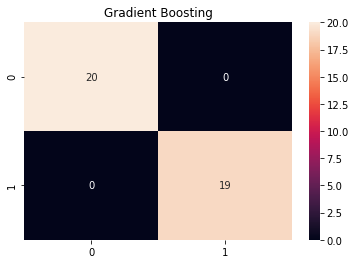

In [32]:
grad_ens_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, gradient_boost))
sns.heatmap(grad_ens_conf_matrix, annot=True,  fmt='');
title = 'Gradient Boosting'
plt.title(title);

### Support Vector Machines

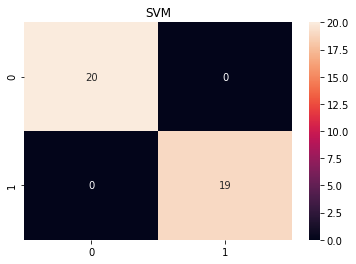

In [33]:
svm_svc_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, svc_model))
sns.heatmap(svm_svc_conf_matrix, annot=True,  fmt='');
title = 'SVM'
plt.title(title);

### Random Forest

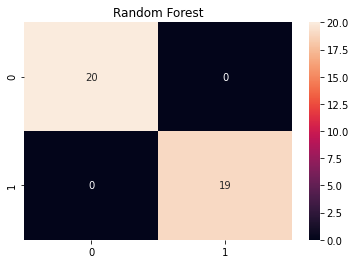

In [34]:
random_forest_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, random_forest))
sns.heatmap(random_forest_conf_matrix, annot=True,  fmt='');
title = 'Random Forest'
plt.title(title);

### Classification Report

In [35]:
print('Gradient Boosting Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, gradient_boost))))
print('Support vector machine(SVM):\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, svc_model))))
print('Random Forest Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, random_forest))))

Gradient Boosting Classifier:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        19

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39


Support vector machine(SVM):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        19

    accuracy                           1.00        39
   macro avg       1.00      1.00      1.00        39
weighted avg       1.00      1.00      1.00        39


Random Forest Classifier:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        19

    accuracy                           1.00        39
   macro avg       1.00      1.00     

## Final Model Selection

Gradient Boosting seems to do comparatively better for this case

In [36]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X, y)

GradientBoostingClassifier()

[ 1.31021621e-16 -3.38674562e-19  5.31291159e-17  2.03321982e-16
  1.83542125e-17  1.12181716e-17 -4.63610350e-18  3.31490993e-17
  1.00000000e+00]


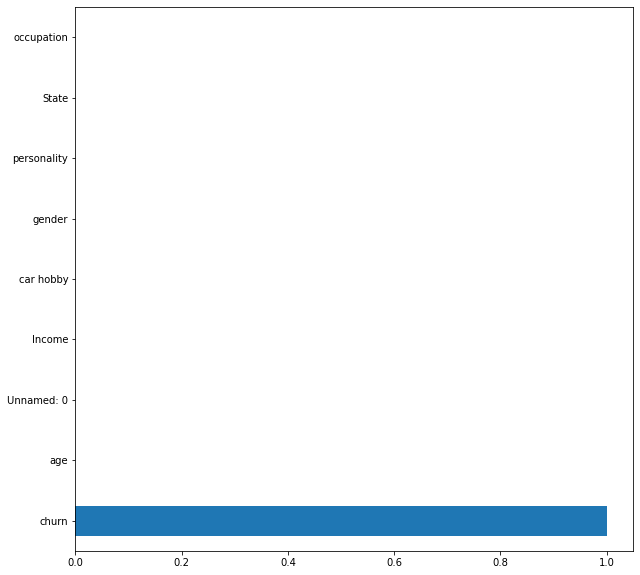

In [37]:
# Get Feature Importance from the classifier
feature_importance = gbc.feature_importances_
print (gbc.feature_importances_)
feat_importances = pd.Series(gbc.feature_importances_, index=df.columns)
feat_importances = feat_importances.nlargest(19)
feat_importances.plot(kind='barh' , figsize=(10,10)) 

## Save and Deploy model to Watson Machine Learning

### Connection to WML

To authenticate the Watson Machine Learning service on IBM Cloud, you will need to provide a platform `api_key` and instance `location`.

You can use the [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) or IBM Cloud console to create your API key.

Using the IBM Cloud CLI:

```bash
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

Retrieve the value of api_key from the output.

```bash
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```

Retrieve the value of location from the output.

Using the IBM Cloud console:

Navigate to the [Users panel](https://cloud.ibm.com/iam#/users). Then click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can retrieve your instance location in your [Watson Machine Learning (WML) Service](https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/) instance details.

You can also get service specific apikey by going to the [Service IDs section of the Cloud Console](https://cloud.ibm.com/iam/serviceids). From that page, click **Create**, then copy the created key and paste it below.

**NOTE**: You can also get a service specific url. Go to the [Endpoint URLs section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning) for details.

In [40]:
api_key = 'kpNJbsqwSltRpWIshLhpm5Z-I4yjnTLAn37FFwx_pghB'
location = 'us-south'

In [41]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the ibm-watson-machine-learning package

Note: ibm-watson-machine-learning documentation can be found [here](http://ibm-wml-api-pyclient.mybluemix.net/).

In [42]:
!pip install -U ibm-watson-machine-learning

     |████████████████████████████████| 1.7 MB 21.9 MB/s eta 0:00:01
  Attempting uninstall: ibm-watson-machine-learning
    Found existing installation: ibm-watson-machine-learning 1.0.45
    Uninstalling ibm-watson-machine-learning-1.0.45:
      Successfully uninstalled ibm-watson-machine-learning-1.0.45


In [43]:
# create client to access our WML service
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)
print(client.version)

1.0.45


### Working with spaces

First, create a space that will be used for your work. If you do not have space already created, you can use [Deployment Spaces dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

* Click New Deployment Space
* Create an empty space
* Select Cloud Object Storage
* Select Watson Machine Learning instance and press Create
* Copy space_id and paste it below

**Tip**: You can also use WML SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [44]:
space_id = '11a1f437-6ece-4e35-a5e3-fa00656e3340'

You can use list method to print all existing spaces.

In [45]:
client.spaces.list(limit=10)

------------------------------------  -----------------------------  ------------------------
ID                                    NAME                           CREATED
11a1f437-6ece-4e35-a5e3-fa00656e3340  customer-churn-luxury-vehicle  2021-02-27T23:17:30.078Z
a55d2045-05cb-4667-87aa-3da5f3206f30  workshop-deployments           2020-12-27T21:32:40.843Z
------------------------------------  -----------------------------  ------------------------


To be able to interact with all resources available in Watson Machine Learning, you need to set the **space** which you will be using.

In [46]:
client.set.default_space(space_id)

'SUCCESS'

### Upload model

In this section you will learn how to upload the model to the Cloud.

In [47]:
sofware_spec_uid = client.software_specifications.get_id_by_name("default_py3.7")
metadata = {
            client.repository.ModelMetaNames.NAME: 'Gradient Boosting model to predict customer churn',
            client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

published_model = client.repository.store_model(
    model=gbc,
    meta_props=metadata)

Use the following command to get details about the model

In [48]:
# Get model details
import json

published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "software_spec": {
      "id": "e4429883-c883-42b6-87a8-f419d64088cd",
      "name": "default_py3.7"
    },
    "type": "scikit-learn_0.23"
  },
  "metadata": {
    "created_at": "2021-02-28T00:31:50.650Z",
    "id": "6c27a204-7744-4507-96a4-e2d37cff2ecc",
    "modified_at": "2021-02-28T00:31:54.488Z",
    "name": "Gradient Boosting model to predict customer churn",
    "owner": "IBMid-550006EJ0N",
    "space_id": "11a1f437-6ece-4e35-a5e3-fa00656e3340"
  },
  "system": {
    "warnings": []
  }
}


Note: You can see that model is successfully stored in Watson Machine Learning Service.

In [49]:
client.repository.list_models()

------------------------------------  -------------------------------------------------  ------------------------  -----------------
ID                                    NAME                                               CREATED                   TYPE
6c27a204-7744-4507-96a4-e2d37cff2ecc  Gradient Boosting model to predict customer churn  2021-02-28T00:31:50.002Z  scikit-learn_0.23
------------------------------------  -------------------------------------------------  ------------------------  -----------------


Use the following command to clean up/delete any previously created models

In [50]:
# client.repository.delete('GUID of stored model')

### Create online deployment

You can use commands bellow to deploy the stored model as a web service.

In [51]:
# Create online deployment
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of customer churn model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(published_model_uid, meta_props=metadata)

{"trace":"18bf3b7510fa33dd4e7bb7701ed01e45","errors":[{"code":"instance_quota_exceeded","message":"This deployment cannot be processed because it exceeds the allocated capacity unit hours (CUH). Increase the compute resources for this job and try again."}]}


--------------------------
Deployment creation failed
--------------------------




WMLClientError: Deployment creation failed. Error: 402. {"trace":"18bf3b7510fa33dd4e7bb7701ed01e45","errors":[{"code":"instance_quota_exceeded","message":"This deployment cannot be processed because it exceeds the allocated capacity unit hours (CUH). Increase the compute resources for this job and try again."}]}

Use the following commands to retrieve the deployment UID, show all deployments, and to delete old deployments.

In [ ]:
# Get deployment UID and show details on the deployment
deployment_uid = client.deployments.get_uid(created_deployment)
client.deployments.get_details(deployment_uid)

In [ ]:
# list all deployments
client.deployments.list()

In [ ]:
# delete old deployments
# client.deployments.delete('GUID of deployed model')

### Scoring

You can send new scoring records to the web-service deployment using the WML **score** method.

In [ ]:
# get scoring end point
scoring_endpoint = client.deployments.get_scoring_href(created_deployment)
print(scoring_endpoint)

In [ ]:
# use our WML client to score our model
# add some test data
scoring_payload = {"input_data": [
    {'fields': ['state', 'Income', 'age', 'gender', 'personality', 'occupation', 'car hobby'], 
     'values': [[ 'NV','115,000.00','34','male','disagreeable','attorney','yes]]
    }]}

In [ ]:
# score the model
predictions = client.deployments.score(deployment_uid, scoring_payload)
print('prediction',json.dumps(predictions, indent=2))

## Acknowledgement

The approach and code fragments have been adopted from the nootebook on Kaggle by Sandip Datta (https://www.kaggle.com/sandipdatta). 
The full original notebook can be viewed here: https://www.kaggle.com/sandipdatta/customer-churn-analysis#